In [ ]:
%pip install python-binance

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
^C
Note: you may need to restart the kernel to use updated packages.


In [31]:
import pandas as pd
from binance.client import Client
import numpy as np
import matplotlib.pyplot as plt


In [20]:
# Initialize the Binance client
api_key = 'your_api_key'
api_secret = 'your_api_secret'
client = Client(api_key, api_secret)

# Get historical data for BTCUSDT
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1DAY, "1 Jan, 2010", "28 Feb, 2025")

# Create a DataFrame
df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')

# Set timestamp as index
df.set_index('timestamp', inplace=True)

btc = df[['close']].copy()
print(btc.head())

                    close
timestamp                
2017-08-17  4285.08000000
2017-08-18  4108.37000000
2017-08-19  4139.98000000
2017-08-20  4086.29000000
2017-08-21  4016.00000000


In [21]:
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI for the btc DataFrame
btc['close'] = btc['close'].astype(float)
btc['rsi'] = calculate_rsi(btc['close'], window=14)
print(btc.head(20))

              close        rsi
timestamp                     
2017-08-17  4285.08        NaN
2017-08-18  4108.37        NaN
2017-08-19  4139.98        NaN
2017-08-20  4086.29        NaN
2017-08-21  4016.00        NaN
2017-08-22  4040.00        NaN
2017-08-23  4114.01        NaN
2017-08-24  4316.01        NaN
2017-08-25  4280.68        NaN
2017-08-26  4337.44        NaN
2017-08-27  4310.01        NaN
2017-08-28  4386.69        NaN
2017-08-29  4587.48        NaN
2017-08-30  4555.14  62.719001
2017-08-31  4724.89  67.858274
2017-09-01  4834.91  81.190006
2017-09-02  4472.14  61.102643
2017-09-03  4509.08  64.292040
2017-09-04  4100.11  52.313524
2017-09-05  4366.47  57.923452


In [35]:
btc['signal'] = np.where(btc['rsi'] < 50, 1, np.where(btc['rsi'] > 50, -1, 0))

btc['position'] = 0
for i in range(1, len(btc)):
    btc['position'].iloc[i] = btc['signal'].iloc[i] + btc['position'].iloc[i-1]

btc['cost'] = np.where(btc['signal'] == -1, btc['close'], np.where(btc['signal'] == 1, -btc['close'], 0))

btc['total_cost'] = 0.0

for i in range(1, len(btc)):
    btc['total_cost'].iloc[i] = btc['cost'].iloc[i] + btc['total_cost'].iloc[i-1]

btc['pnl'] = btc['total_cost'] + (btc['position'] * btc['close'])
print(btc.head(-10))

C:\Users\isaac\AppData\Local\Temp\ipykernel_7188\1278990128.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  btc['position'].iloc[i] = btc['signal'].iloc[i] + btc['position'].iloc[i-1]
C:\Users\isaac\AppData\Local\Temp\ipykernel_7188\1278

               close        rsi  signal  position      cost   total_cost  \
timestamp                                                                  
2017-08-17   4285.08        NaN       0         0      0.00         0.00   
2017-08-18   4108.37        NaN       0         0      0.00         0.00   
2017-08-19   4139.98        NaN       0         0      0.00         0.00   
2017-08-20   4086.29        NaN       0         0      0.00         0.00   
2017-08-21   4016.00        NaN       0         0      0.00         0.00   
...              ...        ...     ...       ...       ...          ...   
2025-02-14  97500.48  37.754058       1      -254 -97500.48  10478274.69   
2025-02-15  97569.66  41.668791       1      -253 -97569.66  10380705.03   
2025-02-16  96118.12  45.322871       1      -252 -96118.12  10284586.91   
2025-02-17  95780.00  29.641895       1      -251 -95780.00  10188806.91   
2025-02-18  95671.74  39.718018       1      -250 -95671.74  10093135.17   

           

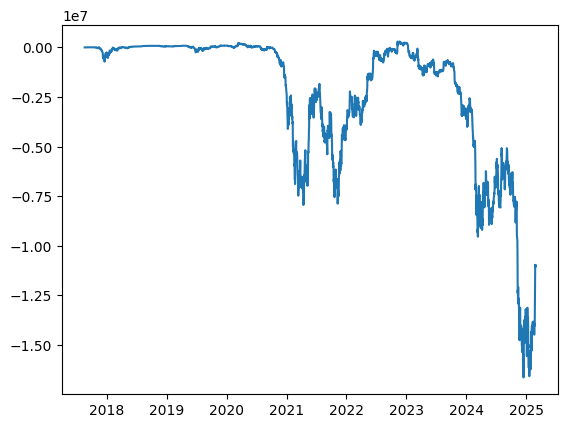

In [36]:
plt.plot(btc['pnl'])